# 이번 기회에 NLP를 공부하면서 많은 것을 배웠습니다. 데이콘 감사해요!

정형 데이터는 lightgbm, xgboost,
이미지 데이터는 CNN,
텍스트 데이터는 RNN이 답이다,라고
배워왔습니다....

하지만 막상 다양한 대회를 진행하며 공부를 하다보니 꼭 모든 것에 정답이 정해져 있는 것은 아니였더군요.
본문에 앞서 해당 내용의 출처를 올립니다.

CNN이 왜why text data를 분석하는거죠...?
    -> http://emnlp2014.org/papers/pdf/EMNLP2014181.pdf

더 많은 내용을 알고 싶습니다
    -> https://www.kaggle.com/criscastromaya/cnn-for-nlp-in-keras

매우 좋은 결과를 내는 것은 아니기에 test set을 predict하는 것까지는 진행하지 않았습니다. 단지 내용 자체가 매우 유의미하다고 생각합니다 :)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\82104\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 전처리

특수문자를 제거해줍니다.

In [2]:
import re
#this are our cleaning rules
cleaningOptions = {
    '[A-Za-z0-9_-]{10,}':'',
    "\'m":" am",
    "\'s":" is",
    "\'ve":" have",
    "n\'t":" not",
    "\'re":" are",
    "\'d":" had",
    "\'ll":" will",
    '\s{2,}|\?{2,}|\!{2,}|#{2,}|={2,}|-{2,}|_{2,}|\.{2,}|\*{2,}|\^{2,}':'',
    '(':' ( ',
    '/':' / ',
    ')':' ) ',
    '?':' ? ',
    '¿':' ¿ ',
    ']':' ] ',
    '[':' [ ',
    '}':' } ',
    '{':' { ',
    '<':' < ',
    '"':' " ',
    '>':' > ',
    ',':' , ',
    '!':' ! ',
    '.':' . ',
    ':':' : ',
    '-':' - ',
    "[A-Za-z0-9_-]*@[A-Za-z0-9._-]*\s?":"",
    "https?://[A-Za-z0-9./-]+":"",
}

def escapePattern(pattern):
    """Helper function to build our regex"""
    if len(pattern)==1:
        pattern=re.escape(pattern)
    return pattern

def compileCleanerRegex(cleaningOptions=None):
    """Given a dictionary of rules this contruct the regular expresion to detect the patterns """
    return re.compile("(%s)" % "|".join(map(escapePattern,cleaningOptions.keys())))

replacementDictRegex = compileCleanerRegex(cleaningOptions)

데이터를 불러와줍니다.

In [4]:
df_train = pd.read_csv("train.csv")

데이터의 분포도를 확인해봅니다. 이쁘군요.

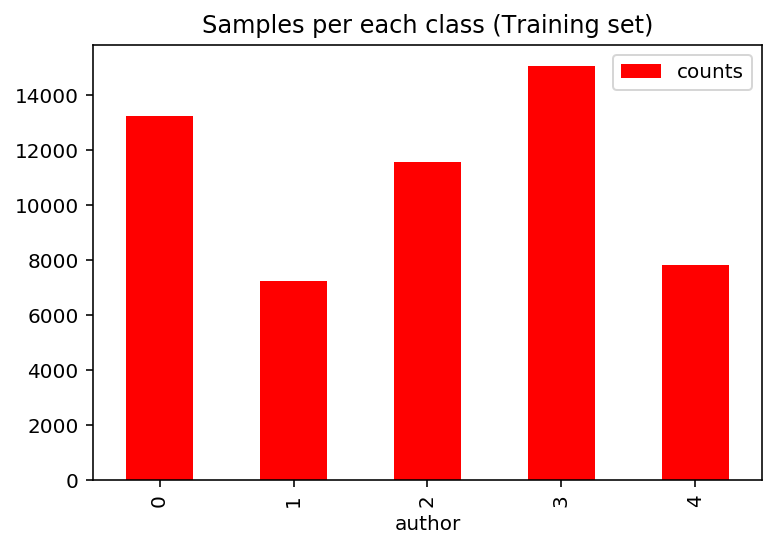

In [5]:
df_train.groupby(df_train.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')

In [6]:
#df_train[df_train.text.str.split(" ").apply(len)==df_train.text.str.split(" ").apply(len).max()]
max_l=df_train.text.str.split(" ").apply(len).max()
min_l=df_train.text.str.split(" ").apply(len).min()
print(f"가장 많은 token을 가진 row는 {max_l}개의 token을, 가장 적은 개수의 token을 가진 row는 {min_l}개의 token을 가지고 있습니다.")

가장 많은 token을 가진 row는 472개의 token을, 가장 적은 개수의 token을 가진 row는 5개의 token을 가지고 있습니다.


문장의 길이도 확인해 봅니다.

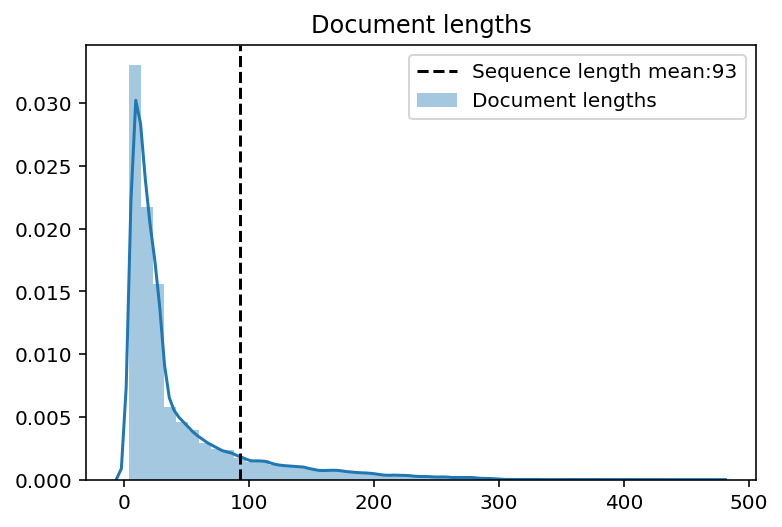

 가장 긴 문장은 471 개의 단어를, 가장 짧은 문장은 4 개의 단어를 가지고 있습니다.


In [7]:
df_train['doc_len'] = df_train.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.doc_len.mean() + dataframe.doc_len.std()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{max_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {df_train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {df_train['doc_len'].min()} 개의 단어를 가지고 있습니다.")
plot_doc_lengths(df_train)

위 그래프에서 확인했듯 평균값은 93이므로 sequence에 적용할 max length를 150 정도로 적당히 잡아줍니다.

In [8]:
max_length=150

이제 train set과 validation set으로 분할하고, tokenize를 진행합니다.

In [9]:
from sklearn.model_selection import train_test_split
SEED = 200
X_train, X_validation, y_train, y_validation = train_test_split(df_train.text, df_train.author, test_size=0.1, random_state=3,stratify= df_train.author)

In [10]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=500000)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_validation = tokenizer.texts_to_sequences(X_validation)

tokenized된 내용을 확인해봅니다.

In [11]:
print(f"Original document: {X_train.values[0]} \nNumerical representation: {sequences_train[0]}")

Original document: “Oh, but it’s only the simple tale of an old soldier who saw the French enter Moscow. Some of his remarks were wonderfully interesting. Remarks of an eye-witness are always valuable, whoever he be, don’t you think so?” 
Numerical representation: [364, 25, 261, 80, 1, 1125, 2319, 4, 51, 116, 2107, 67, 171, 1, 1194, 1458, 1831, 68, 4, 15, 2348, 39, 3699, 1017, 2348, 4, 51, 466, 1525, 49, 178, 2679, 5121, 10, 27, 170, 13, 98, 34, 9]


In [12]:
from keras.preprocessing import sequence
x_train=sequence.pad_sequences(sequences_train,maxlen=max_length)
x_validation=sequence.pad_sequences(sequences_validation,maxlen=max_length)
print(f"Train set shape: {x_train.shape}\nValidation set shape: {x_validation.shape}")

Train set shape: (49391, 150)
Validation set shape: (5488, 150)


In [13]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train_categorical=encoder.fit_transform(y_train.values.reshape(-1, 1))
y_validation_categorical=encoder.transform(y_validation.values.reshape(-1, 1))

In [14]:
print(f"Train set labels: {y_train_categorical.__len__()}\nValidation set labels: {y_validation_categorical.__len__()}")

Train set labels: 49391
Validation set labels: 5488


# 모델

In [15]:
from keras.layers import *
from keras import regularizers
from keras import Sequential,optimizers
from keras_sequential_ascii import keras2ascii

class CNNtext(Sequential):
    """
    This class extends  keras.sequencial in order to build our 
    model according to the designed architecture
    """
    #params for the convolutional layers
    __num_filters = 64
    __weight_decay = 1e-4
    #optimizers
    __adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    def __init__(self,max_length,number_of_classes,embedding_matrix=None,vocab_size=None,tokenizer=None):
        #creating the model heritance from Keras.sequencial
        super().__init__()
        #params for the embedding layer
        self.__embedding_dim=100 if embedding_matrix is None else embedding_matrix.shape[1]
        #self.__vocab_size=vocab_size if tokenizer is None else tokenizer.word_index.__len__()+1
        self.__vocab_size=vocab_size if tokenizer is None else max(tokenizer.index_word.keys())+1
        try:
            self.__max_length=max_length
            self.__number_of_classes=number_of_classes 
        except NameError as error:
            print("Error ",error," must be defined.")
            
        #defining layers
        #This layer will learn an embedding the vocab_size is the vocabulary learn from our tokenizer
        #the embedding dimension is defined by our selfs in this case we choose a dimension of 100
        #the input length is the maximum length of the documents we will use
        if embedding_matrix is None:
            self.add(Embedding(self.__vocab_size,
                               self.__embedding_dim,
                               input_length=self.__max_length,trainable=True))
        else:
            self.add(Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               weights=[embedding_matrix],
                               input_length=self.__max_length,
                               trainable=False))
        #then we apply a 1D conv layer that should apply filters to the sequence and generate features maps.
        self.add(Conv1D(self.__num_filters, 7, activation='relu', padding='same'))
        #then we will get the most important features using a max pooling layer
        self.add(MaxPooling1D(2))
        #afterwards we apply a conv 1D layer to learn new features form the previous results
        self.add(Conv1D(self.__num_filters, 7, activation='relu', padding='same'))
        #we select again the most important features
        self.add(GlobalMaxPooling1D())
        #then we apply dropout to improve the generalization
        self.add(Dropout(0.5))
        #then we will pass the results into a dense layer that will also learn some internal representation and we also use the l2 regularization
        self.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(self.__weight_decay)))
        #for the final layer we will use softmax to obtain the probabilities of each class.
        self.add(Dense(self.__number_of_classes, activation='softmax'))  
        #to compute the loss function we use binary_crossentropy
        #which is widely used for multi-classification problems
        #we also use the adam optimazer to learn the parameters(weights)
        #and minimize the loss function.
        # 몰랐는데 binary_crossentropy가 multi-classification 에 좋다고 하는군요.
        # binary_crossentropy는 반드시 binary-classification에만 써야 하는건줄 알았는데...
        self.compile(loss='binary_crossentropy', optimizer=self.__adam, metrics=['accuracy'])

# (CNN+BOW)로 학습하기

In [16]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1)

In [17]:
#training params
batch_size = 64
num_epochs = 10

In [18]:
tokenizer.num_words

500000

In [19]:
CNN_BOW=CNNtext(max_length,
              encoder.classes_.__len__(),
              tokenizer=tokenizer)

In [20]:
keras2ascii(CNN_BOW)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         150
           Embedding   emb | -------------------   4062700    98.2%
                       #####    150  100
              Conv1D    \|/  -------------------     44864     1.1%
                relu   #####    150   64
        MaxPooling1D   Y max -------------------         0     0.0%
                       #####     75   64
              Conv1D    \|/  -------------------     28736     0.7%
                relu   #####     75   64
  GlobalMaxPooling1D   Y^max -------------------         0     0.0%
                       #####          64
             Dropout    | || -------------------         0     0.0%
                       #####          64
               Dense   XXXXX -------------------      2080     0.1%
                relu   #####          32
               Dense   XXXXX -------------------       165     0.0%
             softmax   #####           5


In [21]:
hist = CNN_BOW.fit(x_train, y_train_categorical,
                 batch_size=batch_size, epochs=num_epochs, callbacks=[es],
                 validation_data=(x_validation,y_validation_categorical),
                 shuffle=True)

Epoch 1/10
772/772 [==============================] - 67s 87ms/step - loss: 0.3512 - accuracy: 0.5748 - val_loss: 0.2423 - val_accuracy: 0.7372
Epoch 2/10
772/772 [==============================] - 68s 88ms/step - loss: 0.2097 - accuracy: 0.7816 - val_loss: 0.2169 - val_accuracy: 0.7728
Epoch 3/10
772/772 [==============================] - 70s 91ms/step - loss: 0.1500 - accuracy: 0.8486 - val_loss: 0.2230 - val_accuracy: 0.7779
Epoch 4/10
772/772 [==============================] - 68s 88ms/step - loss: 0.1151 - accuracy: 0.8857 - val_loss: 0.2284 - val_accuracy: 0.7819
Epoch 00004: early stopping


In [22]:
def plot_model_perfomance(hist,name):
    plt.style.use('fivethirtyeight')
    plt.figure(1)
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.figure(2)
    plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

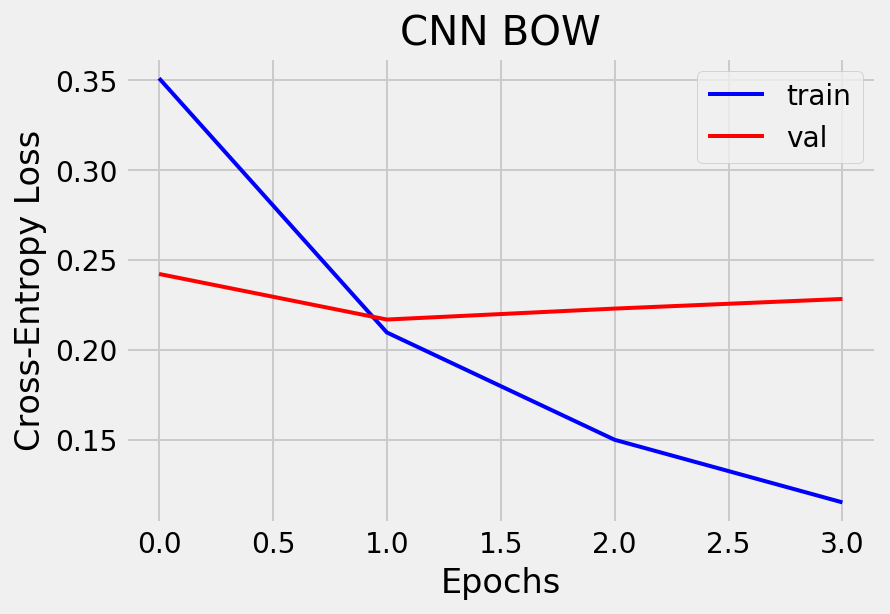

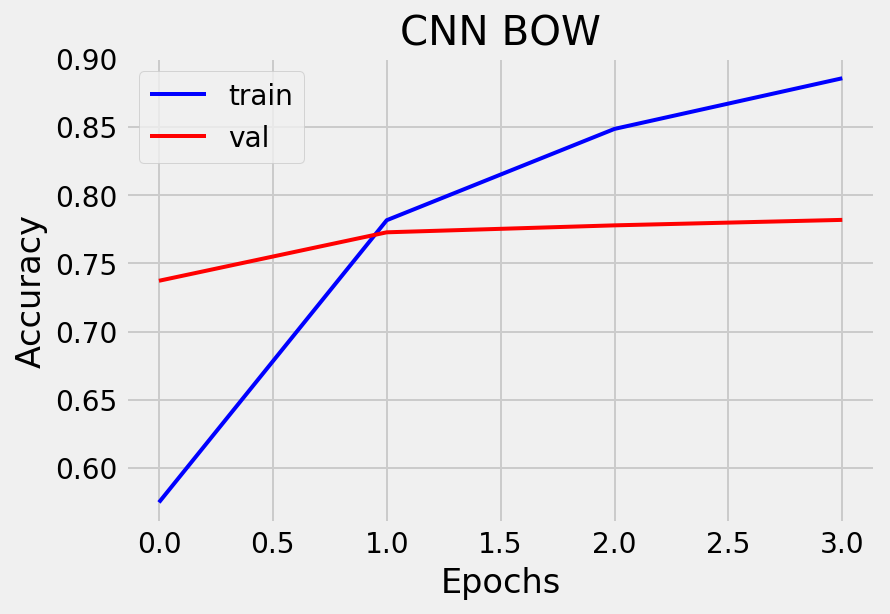

In [23]:
plot_model_perfomance(hist,'CNN BOW')

In [24]:
bow_predict_y_validation = CNN_BOW.predict(x_validation,verbose=1)

172/172 [==============================] - 2s 12ms/step


In [25]:
bow_predict_y_validation= encoder.inverse_transform(bow_predict_y_validation)

In [26]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y=None,y_predict=None,classes=None,name=None):
    plt.figure(figsize=(30, 30))
    sns.heatmap(confusion_matrix(y,y_predict), 
                xticklabels=classes,
                yticklabels=classes)
    plt.title(name)
    plt.show()

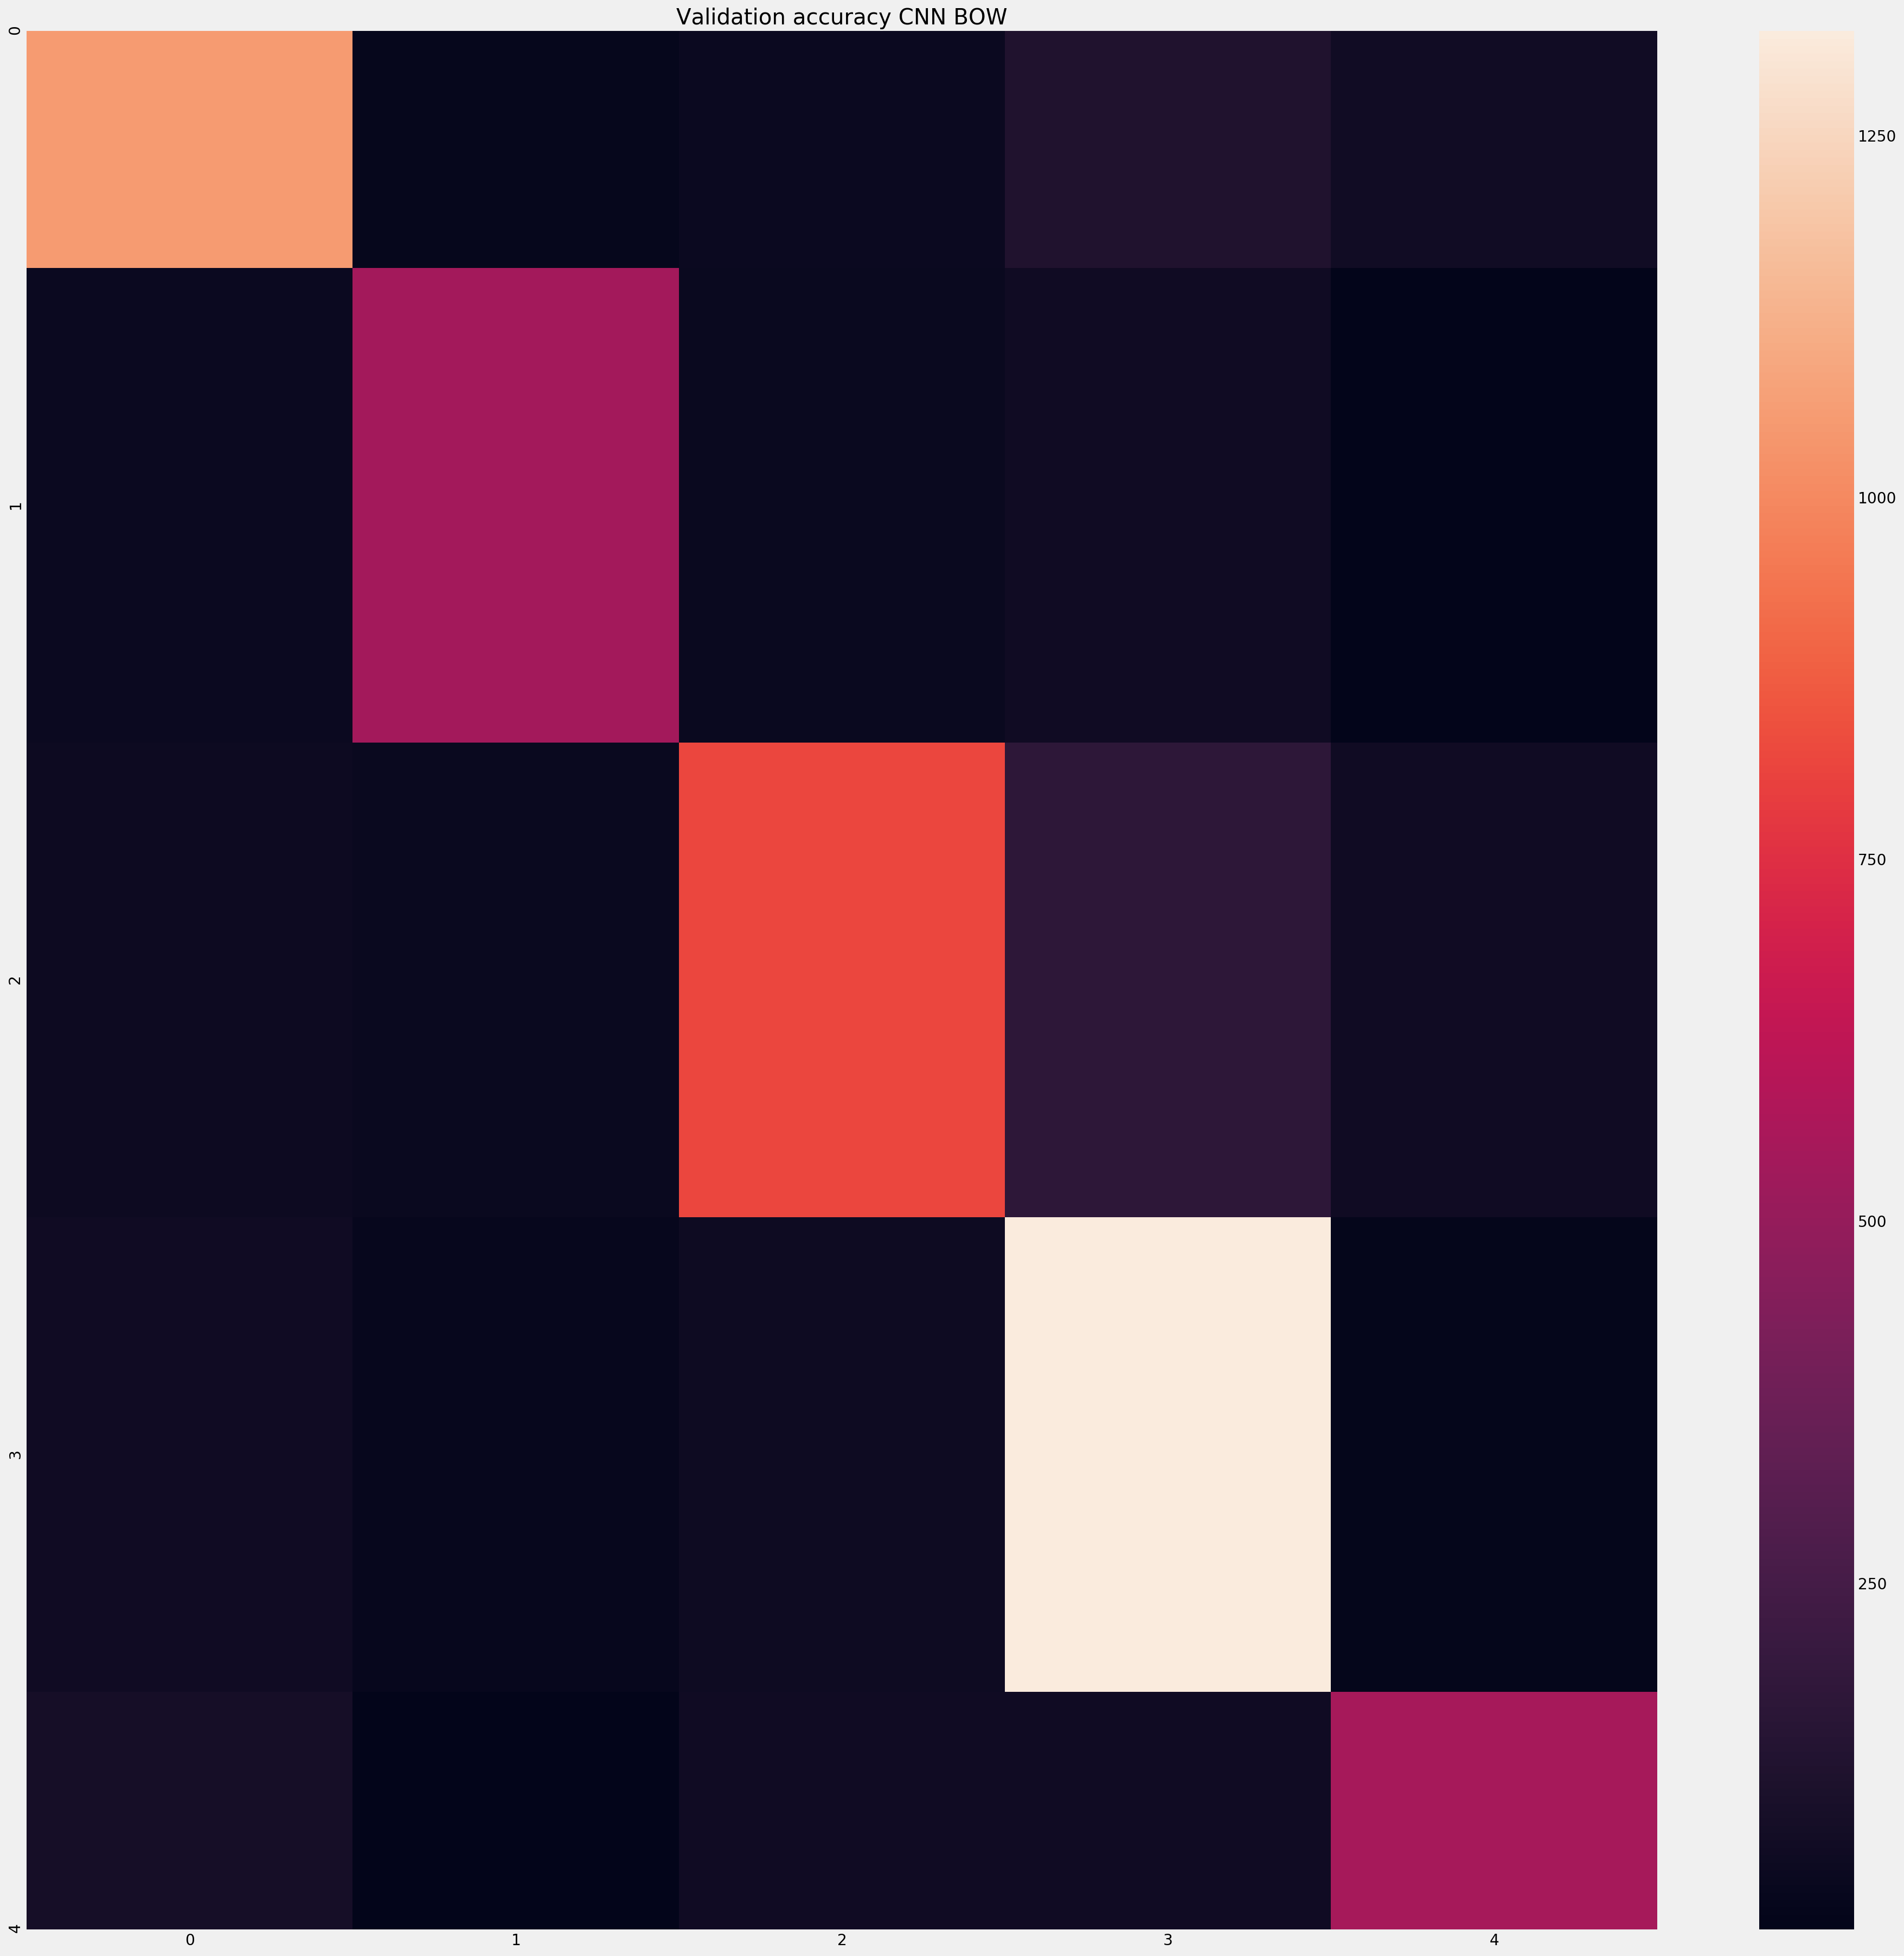

In [27]:
plot_confusion_matrix(y_validation,bow_predict_y_validation,encoder.classes_,'Validation accuracy CNN BOW')

In [28]:
# https://www.kaggle.com/criscastromaya/cnn-for-nlp-in-keras